# Compare ideal infomax filter with the retina's horizontal and amacrine cell projective fields

In [8]:
import numpy as np
from scipy.stats import sem

# import my functions
import info_theory_functions as info
from lnl_model_functions import *
from atick_redlich_functions import *
from get_davids_data import *
from image_processing_functions import *

# from scipy.optimize import minimize
# from scipy import fft, arange
# from random import randint
# from cmath import polar
# from numpy.fft import fft2
# from numpy.fft import fftshift
# from sklearn.decomposition import PCA
# from scipy.interpolate import interp1d
# from scipy.optimize import curve_fit


# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
from matplotlib.pyplot import *

# note that nonposx(y) for log plots will no longer work with this package
# I recommend against enabling the whole notebook, since some plots come out funny.
# Instead, just use mpld3.display() at the end of cells you want to interact with.
import mpld3
#mpld3.enable_notebook()

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import natural images

In [16]:
# choose an image path from cd13A (flood plain, water, horizon) or cd01A (baboons, trees, bushes)
im_path     = '/Users/lmcintosh/Documents/Natural_Images/RawData/cd13A' # flood plain, water, horizon
num_images  = 100
patch_size  = None
pixelsToDeg = 92./2 # or 2./92 degrees per pixel (spacing)
spacing     = 1./pixelsToDeg # number of degree spacing between pixels
normalize   = 'divisive'
patches     = load_images(im_path, num_images, patch_size, square=True, normalize=normalize)

Only 78 files in directory.


In [17]:
allRot  = [spectrum2d(p,spacing=spacing,frequencyFlag=False) for p in patches]
specRot = mean(allRot, axis=0) # average out the amplitude spectrum over all images
frqRot, tmp = spectrum2d(patches[0],spacing=spacing,frequencyFlag=True)
error = [sem([allRot[j][i] for j in range(len(patches))]) for i in range(len(frqRot))]
originalSpectra = specRot
originalErrors  = error
originalFreqs   = frqRot

# Get the projective fields of horizontal and amacrine cells

In [22]:
microns_per_deg  = 50.
horz_spatial_pfs = get_horizontal_projective_field(micronsPerDeg=microns_per_deg)
ama_spatial_pfs  = get_amacrine_projective_field(micronsPerDeg=microns_per_deg)

# Compare ideal and experimental filters

In [80]:
ins = np.logspace(-5, 2, 10)

In [81]:
ins

array([  1.00000000e-05,   5.99484250e-05,   3.59381366e-04,
         2.15443469e-03,   1.29154967e-02,   7.74263683e-02,
         4.64158883e-01,   2.78255940e+00,   1.66810054e+01,
         1.00000000e+02])

The relative error from this choice of Lagrangian multiplier is 1.64920619546e-10.


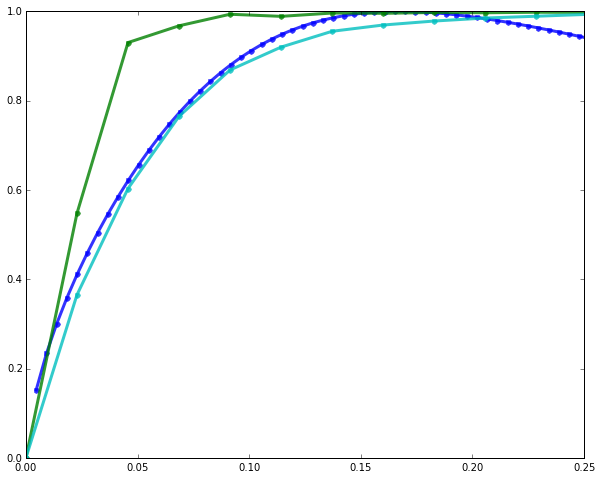

In [101]:
freq_ideal, filt_ideal, freq_expt, filt_expt = compare_to_experiment(originalFreqs, originalSpectra**2, 
                                                                     inputNoise=0.02, outputNoise=0.000001,
                                                                     returnFlag=True, xlimit=[0,0.25], 
                                                                     numPoints=5000, plotFlag='separate')

In [ ]:
filt = soln(originalSpectra**2, 0.025, 0.005, 192845.89786)
plot(originalFreqs, filt/np.max(filt[~isnan(filt)]), 'b.', markersize=10)
plot(horzOnlyF, 1-horzOnlyFilter/np.max(horzOnlyFilter), 'g.', markersize=10)
plot(amaOnlyF, 1-amaOnlyFilter/np.max(amaOnlyFilter), 'c.', markersize=10)
xlim([0,0.25])